Tutorial: Convergence Failure Analysis with FEniCSx
Material properties: mu=384.615, kappa=833.333

Analyzing convergence across different loads

Analyzing load q=-0.50
  Trying with 1 steps... SUCCESS: Tip displacement = -5.616733, Total iterations = 10

Analyzing load q=-1.53
  Trying with 1 steps... 

FAILED: Error at step 1: Newton solver did not converge because maximum number of iterations reached
  Trying with 3 steps... FAILED: Error at step 2: Newton solver did not converge because maximum number of iterations reached
  Trying with 5 steps... SUCCESS: Tip displacement = -8.504956, Total iterations = 47

Analyzing load q=-2.55
  Trying with 1 steps... FAILED: Error at step 1: Newton solver did not converge because maximum number of iterations reached
  Trying with 3 steps... FAILED: Error at step 2: Newton solver did not converge because maximum number of iterations reached
  Trying with 5 steps... FAILED: Error at step 2: Newton solver did not converge because maximum number of iterations reached
  Trying with 7 steps... SUCCESS: Tip displacement = -9.076868, Total iterations = 59

Analyzing load q=-3.58
  Trying with 1 steps... FAILED: Error at step 1: Newton solver did not converge because maximum number of iterations reached
  Trying with 3 steps... FAILED: Error at step 1:

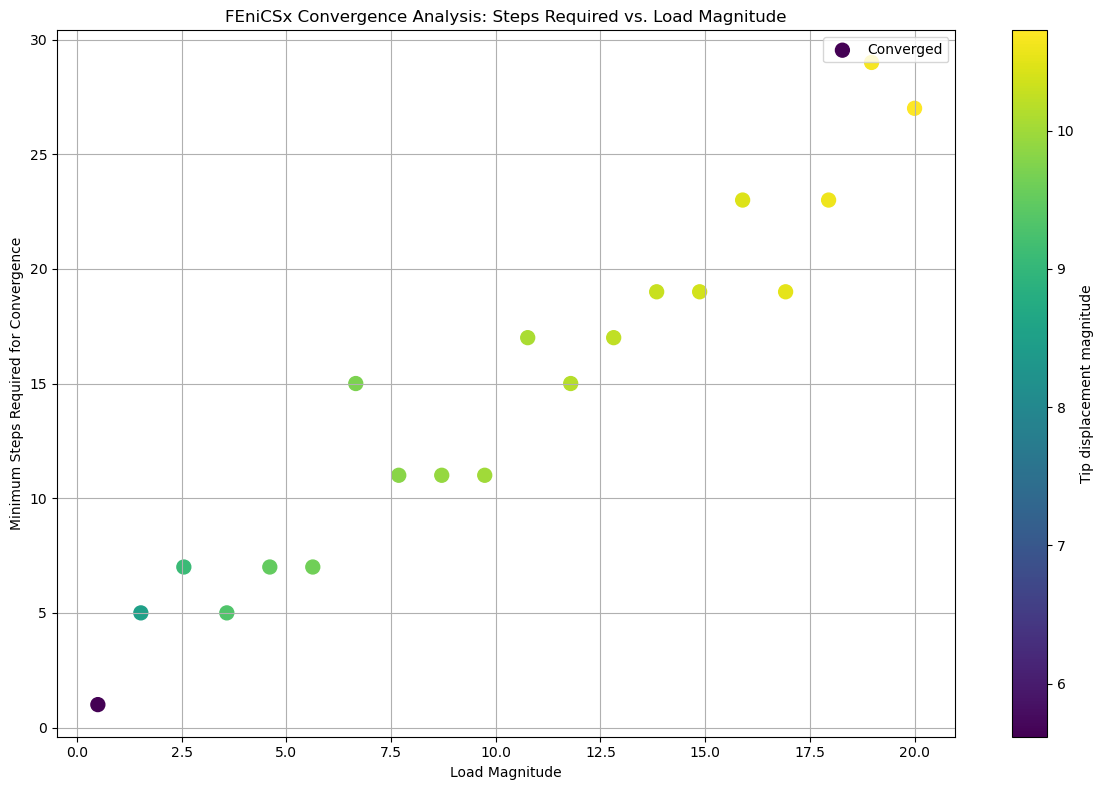

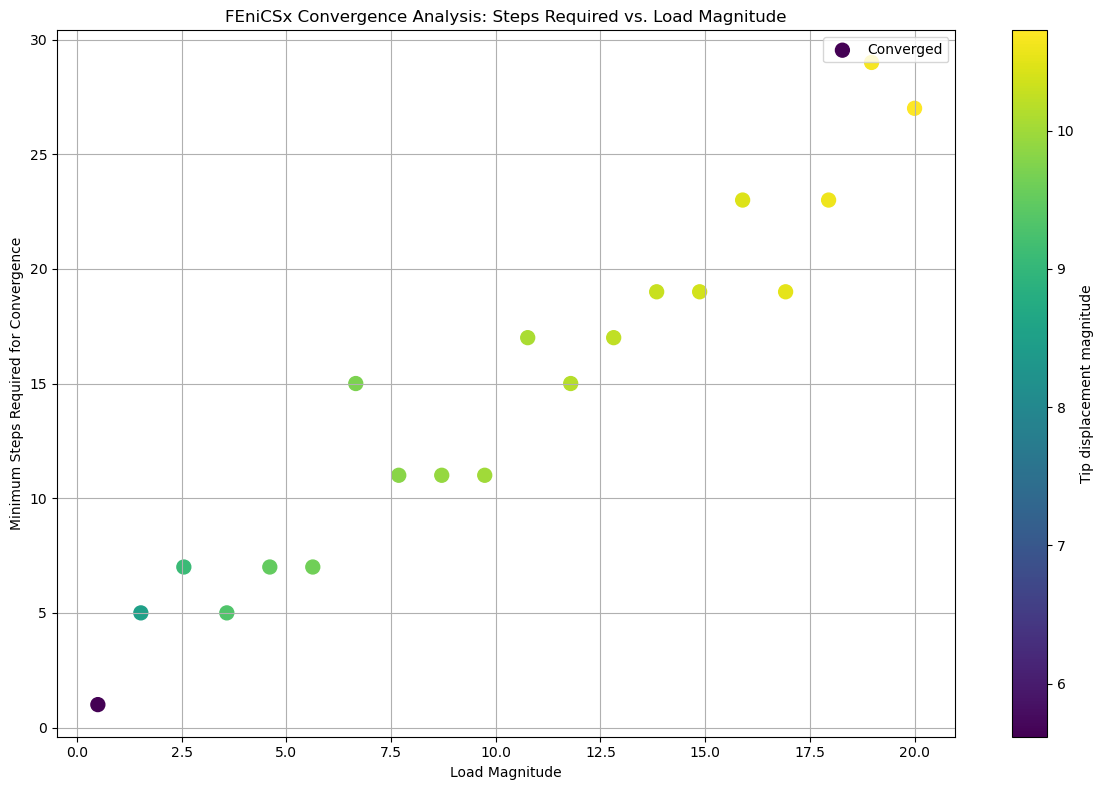


----- Convergence Summary -----
Load       Converged  Min Steps  Tip Disp        Iterations
------------------------------------------------------------
-0.50      Yes        1          -5.616733       10        
-1.53      Yes        5          -8.504956       47        
-2.55      Yes        7          -9.076868       59        
-3.58      Yes        5          -9.327878       45        
-4.61      Yes        7          -9.491216       58        
-5.63      Yes        7          -9.618758       60        
-6.66      Yes        15         -9.727567       107       
-7.68      Yes        11         -9.824958       79        
-8.71      Yes        11         -9.914708       79        
-9.74      Yes        11         -9.999044       77        
-10.76     Yes        17         -10.079406      109       
-11.79     Yes        15         -10.156783      100       
-12.82     Yes        17         -10.231889      109       
-13.84     Yes        19         -10.305256      117       
-14.87

In [2]:
from dolfinx import mesh, fem, log, default_scalar_type
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import numpy as np
import ufl
import matplotlib.pyplot as plt  # Import matplotlib without setting backend
from mpi4py import MPI
import os
import time

# Add this line for Jupyter notebook inline plotting
%matplotlib inline

print("Tutorial: Convergence Failure Analysis with FEniCSx")

# Beam geometry
L = 10.0   # length in x
H = 1.0    # height in y

# Material properties
E = 1000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")

def run_analysis(nx, ny, polynomial_order, q, nr_num_steps, nr_tol=1e-10, nr_maxit=30):
    """
    Attempt to solve the cantilever beam problem with specified parameters
    
    Returns:
    - tip_disp_y: Tip displacement (or None if failed)
    - num_iterations: Number of Newton iterations (or None if failed)
    - fail_reason: Reason for failure (or None if successful)
    """
    try:
        # Create mesh
        domain = mesh.create_rectangle(
            MPI.COMM_WORLD, 
            points=[[0.0, 0.0], [L, H]],
            n=[nx, ny],
            cell_type=mesh.CellType.triangle
        )
        
        # Define function space with specified polynomial order
        V = fem.functionspace(domain, ("Lagrange", polynomial_order, (domain.geometry.dim,)))
        
        # Define boundary conditions
        def left_boundary(x): return np.isclose(x[0], 0.0)
        def top_boundary(x): return np.isclose(x[1], H)
        
        # Mark boundaries
        fdim = domain.topology.dim - 1
        left_facets = mesh.locate_entities_boundary(domain, fdim, left_boundary)
        top_facets = mesh.locate_entities_boundary(domain, fdim, top_boundary)
        
        # Create facet tags
        marked_facets = np.hstack([left_facets, top_facets])
        marked_values = np.hstack([
            np.full_like(left_facets, 1),  # left boundary = 1
            np.full_like(top_facets, 2)    # top boundary = 2
        ])
        sorted_indices = np.argsort(marked_facets)
        facet_tag = mesh.meshtags(
            domain, fdim, 
            marked_facets[sorted_indices], 
            marked_values[sorted_indices]
        )
        
        # Define fixed left boundary condition
        u_bc = np.array((0, 0), dtype=default_scalar_type)
        left_dofs = fem.locate_dofs_topological(V, fdim, facet_tag.find(1))
        bcs = [fem.dirichletbc(u_bc, left_dofs, V)]
        
        # Define solution and test functions
        u = fem.Function(V, name="Displacement")
        v = ufl.TestFunction(V)
        
        # Neo-Hookean hyperelastic model
        d = len(u)
        I = ufl.variable(ufl.Identity(d))
        F = ufl.variable(I + ufl.grad(u))      # Deformation gradient
        C = ufl.variable(F.T * F)              # Right Cauchy-Green tensor
        Ic = ufl.variable(ufl.tr(C))           # First invariant of C
        J = ufl.variable(ufl.det(F))           # Volume ratio
        
        # Stored energy density (Neo-Hookean)
        psi = (mu / 2) * (Ic - d) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
        
        # First Piola-Kirchhoff stress tensor
        P = ufl.diff(psi, F)
        
        # Define distributed load on top edge
        t = fem.Constant(domain, default_scalar_type((0, 0)))
        
        # Define measures for integration
        dx = ufl.Measure("dx", domain=domain)
        ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)
        
        # Variational form (internal - external forces)
        F_internal = ufl.inner(P, ufl.grad(v)) * dx
        F_external = ufl.inner(t, v) * ds(2)   # Applied on top edge (tag 2)
        F_form = F_internal - F_external
        
        # Set up nonlinear solver
        problem = NonlinearProblem(F_form, u, bcs)
        solver = NewtonSolver(MPI.COMM_WORLD, problem)
        solver.convergence_criterion = "incremental"
        solver.rtol = nr_tol
        solver.atol = nr_tol
        solver.max_it = nr_maxit
        
        # Apply load incrementally for better convergence
        num_iterations_total = 0
        step_size = 1.0 / nr_num_steps
        
        for step in range(1, nr_num_steps + 1):
            # Update load gradually
            t.value = (0, q * step * step_size)
            
            # Solve the problem
            try:
                num_its, converged = solver.solve(u)
                num_iterations_total += num_its
                
                if not converged:
                    return None, None, f"Newton solver did not converge at step {step}"
                
                u.x.scatter_forward()
            except Exception as e:
                return None, None, f"Error at step {step}: {str(e)}"
        
        # Find the tip node (middle of right edge)
        def find_tip_node(coords):
            """Find the node closest to the middle of the right edge"""
            right_edge_tol = 1e-10
            right_edge_nodes = np.where(np.isclose(coords[:, 0], L, atol=right_edge_tol))[0]
            if len(right_edge_nodes) == 0:
                return None
                
            # Find the node closest to the middle height
            middle_height = H / 2
            distances = np.abs(coords[right_edge_nodes, 1] - middle_height)
            closest_idx = np.argmin(distances)
            return right_edge_nodes[closest_idx]
        
        # Get coordinates of all nodes
        coords = domain.geometry.x
        
        # Find tip node
        tip_node = find_tip_node(coords)
        if tip_node is None:
            return None, None, "Could not find tip node at x=L"
        
        # Get displacement at tip node
        u_values = u.x.array.reshape(-1, 2)
        tip_disp_y = u_values[tip_node, 1]  # y-component
        
        return tip_disp_y, num_iterations_total, None
        
    except Exception as e:
        return None, None, f"Unexpected error: {str(e)}"

print("\nAnalyzing convergence across different loads")

# Define a range of loads to test (increasing in magnitude)
loads = np.linspace(-0.5, -20.0, 20)

# Define a range of steps to try for each load
max_steps = 50
steps_to_try = range(1, max_steps + 1, 2)  # Try 1, 3, 5, ... steps

# Dictionary to store results
results = {}

# For timing
start_time = time.time()

for q in loads:
    results[q] = {}
    print(f"\nAnalyzing load q={q:.2f}")
    
    for steps in steps_to_try:
        print(f"  Trying with {steps} steps...", end=" ", flush=True)
        
        tip_disp, num_iterations, fail_reason = run_analysis(20, 2, 2, q, steps)
        
        if tip_disp is not None and not np.isnan(tip_disp):
            results[q] = {
                'steps': steps,
                'tip_disp': tip_disp,
                'iterations': num_iterations,
                'converged': True
            }
            print(f"SUCCESS: Tip displacement = {tip_disp:.6f}, Total iterations = {num_iterations}")
            break
        else:
            print(f"FAILED: {fail_reason}")
    
    if q not in results or not results[q].get('converged', False):
        results[q] = {
            'steps': None,
            'tip_disp': None,
            'iterations': None,
            'converged': False,
            'fail_reason': fail_reason if 'fail_reason' in locals() else "Failed to converge"
        }
        print(f"  Could not achieve convergence for load {q:.2f} with any number of steps")

elapsed_time = time.time() - start_time
print(f"\nTotal analysis time: {elapsed_time:.1f} seconds")

# Extract data for plotting
load_values = [abs(q) for q in loads]
converged = []
min_steps = []
tip_disps = []
for q in loads:
    if q in results and results[q].get('converged', False):
        converged.append(True)
        min_steps.append(results[q]['steps'])
        tip_disps.append(abs(results[q]['tip_disp']))
    else:
        converged.append(False)
        min_steps.append(None)
        tip_disps.append(None)

# Create arrays for converged and failed cases
converged_loads = [load_values[i] for i in range(len(loads)) if converged[i]]
converged_steps = [min_steps[i] for i in range(len(loads)) if converged[i]]
converged_disps = [tip_disps[i] for i in range(len(loads)) if converged[i]]

failed_loads = [load_values[i] for i in range(len(loads)) if not converged[i]]

# Plot results
plt.figure(figsize=(12, 8))

# Plot converged results
if converged_loads:
    sc = plt.scatter(converged_loads, converged_steps, c=converged_disps, 
                    cmap='viridis', s=100, label='Converged')
    plt.colorbar(sc, label='Tip displacement magnitude')

# Mark the failed loads
if failed_loads:
    plt.axvspan(min(failed_loads), max(failed_loads), color='red', alpha=0.2, 
               label='Convergence Failure Region')
    for fail_load in failed_loads:
        plt.axvline(x=fail_load, color='red', linestyle='--', alpha=0.5)

plt.xlabel('Load Magnitude')
plt.ylabel('Minimum Steps Required for Convergence')
plt.title('FEniCSx Convergence Analysis: Steps Required vs. Load Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  # Show plot in notebook instead of saving

# Display summary table
print("\n----- Convergence Summary -----")
print(f"{'Load':<10} {'Converged':<10} {'Min Steps':<10} {'Tip Disp':<15} {'Iterations':<10}")
print("-" * 60)
for i, q in enumerate(loads):
    if converged[i]:
        print(f"{q:<10.2f} {'Yes':<10} {min_steps[i]:<10d} {results[q]['tip_disp']:<15.6f} {results[q]['iterations']:<10d}")
    else:
        print(f"{q:<10.2f} {'No':<10} {'N/A':<10} {'N/A':<15} {'N/A':<10}")

# Save results to file
with open("convergence_results.txt", "w") as f:
    f.write("Convergence Failure Analysis Results\n")
    f.write("===================================\n\n")
    f.write(f"Material properties: E={E}, nu={nu}, mu={mu:.3f}, kappa={kappa:.3f}\n\n")
    
    f.write(f"{'Load':<10} {'Converged':<10} {'Min Steps':<10} {'Tip Disp':<15} {'Iterations':<10} {'Fail Reason':<30}\n")
    f.write("-" * 90 + "\n")
    
    for q in loads:
        if q in results:
            if results[q].get('converged', False):
                f.write(f"{q:<10.2f} {'Yes':<10} {results[q]['steps']:<10d} {results[q]['tip_disp']:<15.6f} {results[q]['iterations']:<10d} {'':<30}\n")
            else:
                fail_reason = results[q].get('fail_reason', 'Unknown')
                f.write(f"{q:<10.2f} {'No':<10} {'N/A':<10} {'N/A':<15} {'N/A':<10} {fail_reason[:30]:<30}\n")
        else:
            f.write(f"{q:<10.2f} {'No':<10} {'N/A':<10} {'N/A':<15} {'N/A':<10} {'No results':<30}\n")

print("Saved detailed results to convergence_results.txt")